# An Analysis of Vibrating Euler-Bernoulli Beams
### using Finite Element, Newmark and Eigenvalue Methods
Dylan Everingham, Sebastian Myrbäck, Sergi Andreu, Carsten van de Kamp
September 2021

nb_NewmarkMethod.ipynb

This notebook generates an animation of the dynamic case solutio, and plots examining the energy evolution of the system, both found with the Newmark method.

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import numpy as np

from meshes import *

from NumericalSolutions import *
from DynamicSolutions import *

plt.style.use("standard.mplstyle")

## Mesh Generation

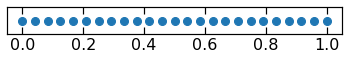

In [2]:
# Spatial resolution of mesh
N = 25

# Right limit of mesh
L = 1

# Generate 1D mesh
[nodes, elems, faces] = get_mesh_1D(N, [0,L], True);

In [3]:
# Problem parameters
E = 1
I = 1
mu = 1
M0 = 0
ML = 0
QL = 0
a0 = 0
aL = 0
a = 0
b = 0
q = 1
two_sided_support = True 

if two_sided_support:
    boundary_conditions = {'M0': M0, 'ML': ML, 'a0': a0, 'aL': aL}
else:
    boundary_conditions = {'QL': QL, 'ML': ML, 'a': a, 'b': b}

## Dynamic Case Animation

In [4]:
# Generate dynamic solution
tsteps = 500
h = 0.001
DynamicCase = DynamicSolutionBothEnds(E=E, I=I, N=N, L=L, h=h,
                                      initial_conditions = {"ML":ML, "M0":M0, "a0":a0, "aL":aL, "q":0},
                                      parameters = {"ML":ML, "M0":M0, "a0":0, "aL":0, "q":10})
DynamicCase.Newmark.run(tsteps);

In [5]:
%%capture
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

results = DynamicCase.Newmark.results
w = results["w"]

wmin = np.min(w)
wmax = np.max(w)

fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlim(( 0, L))
ax.set_ylim((wmin - 0.05 , wmax + 0.05))
ax.set_ylabel(r"$w(x)$")
ax.set_xlabel(r"Domain $\Omega$")
plt.title('Moment, Fixed at Both Ends, Dynamic Case')
        
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    line.set_data(nodes, w[i])
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=tsteps, interval=50, 
                               blit=True)

dpi = 200
writer = animation.writers['ffmpeg'](fps=20)
anim.save('./Report/dynamic.mp4',writer=writer,dpi=dpi)

In [ ]:
HTML(anim.to_jshtml())

## Helper Functions for Energy Plot

In [ ]:
def Energy(u, up, M, S, Only_E1=False, Only_E2=False):
    
    up2 = up @ M
    wd2 = up2[:-2][::2]
    wd1 = up[:-2][::2]
    term1 = np.inner(wd2, wd1)
    
    u2 = u @ S
    w2 = u2[:-2][::2]
    w1 = u[:-2][::2]
    term2 = np.inner(w2, w1)

    if Only_E1:
        return term1
    elif Only_E2:
        return term2
    else:
        return term1 + term2
    
def ExternalEnergy(u, q):
    
    w = u[:-2][::2]
    q = q[:-2][::2]
    
    return 2*np.inner(w,q)

## Energy Evolution Plot

In [ ]:
# Generate dynamic solution
tsteps = 5000
h = 0.001
DynamicCase = DynamicSolutionBothEnds(E=E, I=I, N=N, L=L, h=h,
                                      initial_conditions = {"ML":ML, "M0":M0, "a0":a0, "aL":aL, "q":0},
                                      parameters = {"ML":ML, "M0":M0, "a0":0, "aL":0, "q":10})
DynamicCase.Newmark.run(tsteps)

results = DynamicCase.Newmark.results
w = results["w"]
wp = results["wp"]
wd = results["wd"]

u = results["u"]
up = results["up"]
upp = results["upp"]

Me = DynamicCase.Newmark.Me
Se = DynamicCase.Newmark.Se
rhs = DynamicCase.dynamic_object.RHS_ext

E1 = []
E2 = []
E = []
Ext = []

for i in range(1,np.shape(w)[0]):
    E.append(Energy(u[i], up[i], Me, Se))
    E1.append(Energy(u[i], up[i], Me, Se, Only_E1=True))
    E2.append(Energy(u[i], up[i], Me, Se, Only_E2=True))
    Ext.append(ExternalEnergy(u[i], rhs))

In [ ]:
plt.plot(h*np.array([i for i in range(np.shape(E)[0])]), E, label="E")
plt.plot(h*np.array([i for i in range(np.shape(E)[0])]), E1, label="E1")
plt.plot(h*np.array([i for i in range(np.shape(E)[0])]), E2, label="E2")
plt.plot(h*np.array([i for i in range(np.shape(E)[0])]), Ext, label="Ext")
plt.legend()
plt.title("Energy evolution using Newmark Method")
plt.show()